In [24]:
import os
import copy
import random
import math
import time
from statistics import mean
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial.distance import hamming

In [25]:
class City:
    
    def __init__(self, city):
        self.number = city[0]
        self.x = city[1]
        self.y = city[2]
        
    def __repr__(self):
        return f'({self.x},{self.y})'
        
    def __str__(self):
        return f'City No:{self.number}, X:{self.x}, Y:{self.y}'


class TSP:
    def __init__(self, path) -> None:
        self.cities = []
        self.city_dict = {}
        self.opt_tour = []
        self.init_tsp(path)
        
    def init_tsp(self, path):
        
        # Populate initial configuration of cities
        file = open(f'tsp_files/vlsi/{path}/{path}.tsp').readlines()
        
        self.name = file[0]
        self.size = int(file[5].split(" ")[-1].replace('\n', ''))
        
        for city_line in file[8:-1]:
            city = city_line.split(" ")
            city[1] = int(city[1])
            city[2] = int(city[2].replace('\n', ''))
            
            self.cities.append(City(city))
            
            self.city_dict[city[0]] = City(city)
            
        self.cities.append(self.cities[0])
        
        
        # Store data on optimal path
        file = open(f'tsp_files/vlsi/{path}/{path}.tour').readlines()
        
        self.opt_tour_length = int(file[1].split(" ")[-1].replace("\n", ""))
        
        for city_line in file[5:-2]:
            city_num = city_line.replace("\n", "")
            self.opt_tour.append(self.city_dict[city_num])
            
        self.opt_tour.append(self.opt_tour[0])
        
    def set_cities(self, cities):
        self.cities = cities
        
    def get_cities(self):
        return copy.deepcopy(self.cities)
    
    def cities_to_numbers(self, cities):
        return copy.deepcopy([city.number for city in cities])
    
    def numbers_to_cities(self, city_num_list):
        return [self.city_dict[num] for num in city_num_list]
    
    def cities_to_points(self, cities):
        return [(city.x, city.y) for city in cities]

In [98]:
class Chromosome:
    
    def __init__(self, cities):
        
        self.cities = cities
        self.fitness = None
        
    def __repr__(self):
        return f"(Fitness: {self.fitness}, {self.cities[:2]} ... {self.cities[-2:]})"
    
    def __str__(self):
        return f"Fitness: {self.fitness}\n{self.cities}"
    
    def set_fitness(self, fitness):
        self.fitness = fitness

class GeneticAlgorithm:
    
    def __init__(self, pop_size, cross_prop, mut_rate, num_gens, tsp):
        self.POP_SIZE = pop_size
        self.cross_prop = cross_prop
        self.mut_rate = mut_rate
        self.num_generations = num_gens
        self.population = []
        self.tsp = tsp
        
        self.init_population(tsp, 1024)
        
        self.first_population = copy.deepcopy(self.population)
        
    def init_population(self, tsp, init_size):
        
        for i in range(init_size):
            temp_tsp = copy.deepcopy(tsp)
            temp_city_list = temp_tsp.get_cities()
            start_city = temp_city_list[0]
            temp_city_list = temp_city_list[1:-1]
            
            random.shuffle(temp_city_list)
            temp_city_list.insert(0, start_city)
            temp_city_list.insert(len(temp_city_list), start_city)
            
#             temp_tsp.set_cities(temp_city_list)

            chrm = Chromosome(temp_city_list)
            
            self.population.append(chrm)
            
    def eval_fitness(self, indv):
        
        total_fitness = 0
        
        for i in range(len(indv.cities)-1):
            total_fitness += math.dist([indv.cities[i].x, indv.cities[i].y], [indv.cities[i+1].x, indv.cities[i+1].y])
            
        return round(total_fitness)
    
    def log_exponential_probability(self, pop_fitness, k):
        probabilities = np.exp(-k * pop_fitness)
        normalized_probabilities = probabilities / np.sum(probabilities)
        return normalized_probabilities
    
    def select_number_index(self, pop_fitness, k):
        probabilities = self.log_exponential_probability(pop_fitness, k)
        selected_index = np.random.choice(len(pop_fitness), p=probabilities)
        return selected_index
    
    def roulette_selection(self, pop):
        select_idx = self.select_number_index(np.array([x.fitness for x in pop]), 0.01)
#         inv_fit_list = [1/x.fitness for x in pop]
#         total_fitness = sum(inv_fit_list)
#         prob_list = [x/total_fitness for x in inv_fit_list]
        
#         rw_rand_num = random.uniform(0.0, sum(prob_list))
#         curr_wheel_fitness = 0

#         for i, indv_prob in enumerate(prob_list):
#             curr_wheel_fitness += indv_prob

#             if rw_rand_num <= curr_wheel_fitness:
#                 return i

        
            
        return select_idx
    
    def book_selection(self, pop, sel_size):
        # Book's implementation of selection
        
        sel_pop = []
        
        while len(sel_pop) < sel_size:
            sel_idx = self.roulette_selection(pop)
            sel_indv = pop.pop(sel_idx)
            sel_pop.append(sel_indv)
                    
        return sel_pop
    
    def pmx_crossover(self, parent_1, parent_2):
        
        child_1 = copy.deepcopy(parent_1)
        child_2 = copy.deepcopy(parent_2)
        
        parent_length = len(parent_1)
        cx_start = random.randint(0, parent_length-1)
        cx_end = random.randint(cx_start, parent_length-1)
        
        p1_region = parent_1[cx_start:cx_end+1]
        p2_region = parent_2[cx_start:cx_end+1]
        
        # Swap genes in parents 
        for i in range(cx_start, cx_end+1):
            child_1[i], child_2[i] = child_2[i], child_1[i]
        
        for i in range(len(child_1)):
            if i < cx_start or i > cx_end:
                while child_1[i] in p2_region:
                    index = p2_region.index(child_1[i])
                    child_1[i] = p1_region[index]
                
                while child_2[i] in p1_region:
                    index = p1_region.index(child_2[i])
                    child_2[i] = p2_region[index]
                    
        return child_1, child_2
    
    def book_crossover(self, pop, cross_size, tsp):
        # Book's implementation of crossover
        # Two Point Crossover
        
        cross_pop = []
        start_point = pop[0].cities[0]
        
        while len(cross_pop) < cross_size:
            p1_idx = self.roulette_selection(pop)
            p2_idx = self.roulette_selection(pop)
            
            while p1_idx == p2_idx:
                p2_idx = self.roulette_selection(pop)
            
            parent_1 = self.tsp.cities_to_numbers(pop[p1_idx].cities[1:-1])
            parent_2 = self.tsp.cities_to_numbers(pop[p2_idx].cities[1:-1])

            child_1, child_2 = self.pmx_crossover(parent_1, parent_2)

            child_1 = tsp.numbers_to_cities(child_1)
            child_2 = tsp.numbers_to_cities(child_2)

            child_1.insert(0, start_point)
            child_1.append(start_point)

            child_2.insert(0, start_point)
            child_2.append(start_point)
            
            cross_pop.append(Chromosome(child_1))
            cross_pop.append(Chromosome(child_2))
            
        return cross_pop
    
    def mutate_city_list(self, cities):
        
        mut_city_idx = random.randint(len(cities))
    
    def book_mutation(self, pop, mut_rate, tsp):
        
        new_pop = []
        
        for city_list in [tsp.cities_to_numbers(indv.cities) for indv in pop]:
            
            temp_list = copy.deepcopy(city_list[1:-1])
            
            if random.random() < mut_rate:
                
                rand_city_idx = random.randint(1, len(temp_list)-1)
                rand_city = temp_list.pop(rand_city_idx)
                
                rand_insert_idx = random.randint(1, len(temp_list)-1)
                
                while rand_city_idx == rand_insert_idx:
                    rand_insert_idx = random.randint(1, len(temp_list)-1)
                
                temp_list.insert(rand_insert_idx, rand_city)
                
            temp_list.insert(0, '1')
            temp_list.append('1')
            
            new_pop.append(temp_list)
            
        return [Chromosome(tsp.numbers_to_cities(indv)) for indv in new_pop]
    
    def sort_population(self, pop):
        
        for indv in pop:
            indv.set_fitness(self.eval_fitness(indv))
            
        pop.sort(key = lambda x: x.fitness)
        
    def book_fit(self):
        generation = 0
        # Definies the amount of chromosomes that will be selected. the last term ensures the size of the crossover population is a multiple of 2 as crossover produces pairs.
        sel_size = self.POP_SIZE - (round(self.cross_prop*self.POP_SIZE) + round(self.cross_prop*self.POP_SIZE)%2)
        #Defines the amount of chromosomes that will come as offspring through crossover
        cross_size = (round(self.cross_prop*self.POP_SIZE) + round(self.cross_prop*self.POP_SIZE)%2)
        
        self.population = copy.deepcopy(self.first_population)
        #Sort the population by their fitness (asc order)
        self.sort_population(self.population)
        
        avg_fitness_per_gen = []
        best_fitness_per_gen = []
        
        print("Begin Book Fit")
        while generation < self.num_generations:
            #Shows progress to completion
            if generation % int(0.1 * self.num_generations) == 0:
                print(f'Training: {generation / int(0.01 * self.num_generations)}%')
            
            temp_pop = copy.deepcopy(self.population)
            sel_pop = self.book_selection(temp_pop, sel_size)

            temp_pop = copy.deepcopy(sel_pop)
            cross_pop = self.book_crossover(temp_pop, cross_size, self.tsp)

            new_pop = sel_pop + cross_pop
            new_pop = self.book_mutation(new_pop, self.mut_rate, self.tsp)
            
            #Sort the population by their fitness (asc order)
            self.sort_population(new_pop)
            
            #Collection for visualizations
            best_fitness_per_gen.append(new_pop[0].fitness)
            avg_fitness_per_gen.append(round(mean([indv.fitness for indv in new_pop]), 2))

            self.population = new_pop
            
            generation+=1
            
        print(f'Completed: 100%\n')
            
        return self.population, best_fitness_per_gen, avg_fitness_per_gen
    
    def tournament_selection(self, pop, winner_size):
        winner_group = []
        elim_group = []
        
        fighter_1_idx = self.roulette_selection(pop)
        fighter_2_idx = self.roulette_selection(pop)
        
        while fighter_1_idx == fighter_2_idx:
            fighter_2_idx = self.roulette_selection(pop)
            
        while len(winner_group) < winner_size:
            fighter_1 = pop[fighter_1_idx]
            fighter_2 = pop[fighter_2_idx]
            
            # Given the nature of the TSP, the lower the fitness the better so the individual with lower fitness is the "winner"
            if fighter_1.fitness <= fighter_2.fitness:
                winner_group.append(fighter_1)
                elim_group.append(fighter_2)
                pop.remove(fighter_1)
                pop.remove(fighter_2)
            else:
                winner_group.append(fighter_2)
                elim_group.append(fighter_1)
                pop.remove(fighter_2)
                pop.remove(fighter_1)
                
            fighter_1_idx = self.roulette_selection(pop)
            fighter_2_idx = self.roulette_selection(pop)

            while fighter_1_idx == fighter_2_idx:
                fighter_2_idx = self.roulette_selection(pop)
                
        return winner_group
        
    def tourn_fit(self):
        
        generation = 0
        # Definies the amount of chromosomes that will be selected. the last term ensures the size of the crossover population is a multiple of 2 as crossover produces pairs.
        sel_size = self.POP_SIZE - (round(self.cross_prop*self.POP_SIZE) + round(self.cross_prop*self.POP_SIZE)%2)
        #Defines the amount of chromosomes that will come as offspring through crossover
        cross_size = (round(self.cross_prop*self.POP_SIZE) + round(self.cross_prop*self.POP_SIZE)%2)
        
        self.population = copy.deepcopy(self.first_population)
        #Sort the population by their fitness (asc order)
        self.sort_population(self.population)
        
        avg_fitness_per_gen = []
        best_fitness_per_gen = []
        
        print("Begin Tournament Fit")
        while generation < self.num_generations:
            #Shows progress to completion
            if generation % int(0.1 * self.num_generations) == 0:
                print(f'Training: {generation / int(0.01 * self.num_generations)}%')
            
            temp_pop = copy.deepcopy(self.population)
            sel_pop = self.tournament_selection(temp_pop, sel_size)

            temp_pop = copy.deepcopy(sel_pop)
            cross_pop = self.book_crossover(temp_pop, cross_size, self.tsp)

            new_pop = sel_pop + cross_pop
            new_pop = self.book_mutation(new_pop, self.mut_rate, self.tsp)
            
            #Sort the population by their fitness (asc order)
            self.sort_population(new_pop)
            
            #Collection for visualizations
            best_fitness_per_gen.append(new_pop[0].fitness)
            avg_fitness_per_gen.append(round(mean([indv.fitness for indv in new_pop]), 2))

            self.population = new_pop
            
            generation+=1
        
        print(f'Completed: 100%\n')
            
        return self.population, best_fitness_per_gen, avg_fitness_per_gen
    
    def level_selection(self, pop, level_size, level_split):
        
        self.sort_population(pop)
        
        upper_level_size = int(level_split[0] * level_size)
        middle_level_size = int(level_split[1] * level_size)
        lower_level_size = (level_size - (upper_level_size + middle_level_size))
        
        # Upper Level
        upper_level_sel = []
        upper_level_population = pop[:int(level_split[0] * self.POP_SIZE)]
        while len(upper_level_sel) < upper_level_size:
            
            chosen_idx = self.roulette_selection(upper_level_population)
            upper_level_sel.append(upper_level_population.pop(chosen_idx))
            
        #Middle Level
        middle_level_sel = []
        middle_level_population = pop[int(level_split[0] * self.POP_SIZE) : (int(level_split[0] * self.POP_SIZE) + int(level_split[1] * self.POP_SIZE))]
        while len(middle_level_sel) < middle_level_size:
            
            chosen_idx = self.roulette_selection(middle_level_population)
            middle_level_sel.append(middle_level_population.pop(chosen_idx))
            
        #Lower Level
        lower_level_sel = []
        lower_level_population = pop[(int(level_split[0] * self.POP_SIZE) + int(level_split[1] * self.POP_SIZE)) :]
        while len(lower_level_sel) < lower_level_size:
            
            chosen_idx = self.roulette_selection(lower_level_population)
            lower_level_sel.append(lower_level_population.pop(chosen_idx))
            
        level_sel = upper_level_sel + middle_level_sel + lower_level_sel
        
        return level_sel
    
    def mentor_crossover(self, pop, cross_size, tsp, num_mentors):
        # Book's implementation of crossover
        # Two Point Crossover
        
        start_point = pop[0].cities[0]
        
        self.sort_population(pop)
        mentors = pop[:num_mentors]
        learners = pop[num_mentors:]
        
        cross_pop = []
        crossover_count = 0
        
        while len(cross_pop) < cross_size:
            mentor_idx = crossover_count%num_mentors
            p2_idx = self.roulette_selection(learners)
            
            parent_1 = self.tsp.cities_to_numbers(mentors[mentor_idx].cities[1:-1])
            parent_2 = self.tsp.cities_to_numbers(pop[p2_idx].cities[1:-1])

            child_1, child_2 = self.pmx_crossover(parent_1, parent_2)

            child_1 = tsp.numbers_to_cities(child_1)
            child_2 = tsp.numbers_to_cities(child_2)

            child_1.insert(0, start_point)
            child_1.append(start_point)

            child_2.insert(0, start_point)
            child_2.append(start_point)
            
            cross_pop.append(Chromosome(child_1))
            cross_pop.append(Chromosome(child_2))
            
            crossover_count += 1
            
        self.sort_population(cross_pop)
            
        return cross_pop
    
    def mentor_fit(self, level_split):
        generation = 0
        # Definies the amount of chromosomes that will be selected. the last term ensures the size of the crossover population is a multiple of 2 as crossover produces pairs.
        sel_size = self.POP_SIZE - (round(self.cross_prop*self.POP_SIZE) + round(self.cross_prop*self.POP_SIZE)%2)
        #Defines the amount of chromosomes that will come as offspring through crossover
        cross_size = ((round(self.cross_prop*self.POP_SIZE) + round(self.cross_prop*self.POP_SIZE)%2)) // 2
        mentor_size = copy.copy(cross_size)
        if cross_size % 2 == 1:
            cross_size += 1
            mentor_size -= 1
        
        self.population = copy.deepcopy(self.first_population)
        #Sort the population by their fitness (asc order)
        self.sort_population(self.population)
        
        avg_fitness_per_gen = []
        best_fitness_per_gen = []
        
        print("Begin Mentor Fit")
        while generation < self.num_generations:
            #Shows progress to completion
            if generation % int(0.1 * self.num_generations) == 0:
                print(f'Training: {generation / int(0.01 * self.num_generations)}%')
            
            temp_pop = copy.deepcopy(self.population)
            sel_pop = self.level_selection(temp_pop, sel_size, level_split)

            temp_pop = copy.deepcopy(sel_pop)
            cross_pop = self.book_crossover(temp_pop, cross_size, self.tsp)
            
            temp_pop = copy.deepcopy(self.population)
            mentor_pop = self.mentor_crossover(temp_pop, mentor_size, self.tsp, 3)
            
            new_pop = sel_pop + cross_pop + mentor_pop
            new_pop = self.book_mutation(new_pop, self.mut_rate, self.tsp)
            
            #Sort the population by their fitness (asc order)
            self.sort_population(new_pop)
            
            #Collection for visualizations
            best_fitness_per_gen.append(new_pop[0].fitness)
            avg_fitness_per_gen.append(round(mean([indv.fitness for indv in new_pop]), 2))

            self.population = new_pop
            
            generation+=1
        
        print(f'Completed: 100%\n')
            
        return self.population, best_fitness_per_gen, avg_fitness_per_gen

In [99]:
def hamming_distance_chromosomes(population, tsp):
    best_list = [tsp.cities_to_numbers(population[0].cities) for i in range(len(population)-1)]
    rest_list = [tsp.cities_to_numbers(indv.cities) for indv in population[1:]]
    
    total_hamming = []
    for x, y in zip(best_list, rest_list):
        total_hamming.append(hamming(x, y) * len(x))
        
    return sum(total_hamming)/len(x)

In [123]:
path = "xqf131"
tsp_1 = TSP(path)

population_size = 300
crossover_prop = 0.7
mutation_rate = 0.2
num_generations = 3000

ga = GeneticAlgorithm(population_size, crossover_prop, mutation_rate, num_generations, tsp_1)

In [124]:
all_book_chromosomes = []
all_tourn_chromosomes = []
all_mentor_chromosomes = []

all_book_fitness_over_gen = []
all_tourn_fitness_over_gen = []
all_mentor_fitness_over_gen = []

all_book_avg_over_gen = []
all_tourn_avg_over_gen = []
all_mentor_avg_over_gen = []
for x in range(1):
    book_chromosomes, book_fitness_over_gen, book_avg_over_gen = ga.book_fit()
    all_book_chromosomes.append(book_chromosomes)
    all_book_fitness_over_gen.append(book_fitness_over_gen)
    all_book_avg_over_gen.append(book_avg_over_gen)
    
    tourn_chromosomes, tourn_fitness_over_gen, tourn_avg_over_gen = ga.tourn_fit()
    all_tourn_chromosomes.append(tourn_chromosomes)
    all_tourn_fitness_over_gen.append(tourn_fitness_over_gen)
    all_tourn_avg_over_gen.append(tourn_avg_over_gen)
    
    mentor_chromosomes, mentor_fitness_over_gen, mentor_avg_over_gen = ga.mentor_fit((0.6, 0.3, 0.1))
    all_mentor_chromosomes.append(mentor_chromosomes)
    all_mentor_fitness_over_gen.append(mentor_fitness_over_gen)
    all_mentor_avg_over_gen.append(mentor_avg_over_gen)

Begin Book Fit
Training: 0.0%
Training: 10.0%
Training: 20.0%
Training: 30.0%
Training: 40.0%
Training: 50.0%
Training: 60.0%
Training: 70.0%
Training: 80.0%
Training: 90.0%
Completed: 100%

Begin Tournament Fit
Training: 0.0%
Training: 10.0%
Training: 20.0%
Training: 30.0%
Training: 40.0%
Training: 50.0%
Training: 60.0%
Training: 70.0%
Training: 80.0%
Training: 90.0%
Completed: 100%

Begin Mentor Fit
Training: 0.0%
Training: 10.0%
Training: 20.0%
Training: 30.0%
Training: 40.0%
Training: 50.0%
Training: 60.0%
Training: 70.0%
Training: 80.0%
Training: 90.0%
Completed: 100%



In [126]:
ex_num = 0

# Best Fitness
print(sorted(all_book_fitness_over_gen[ex_num])[0])
print(sorted(all_tourn_fitness_over_gen[ex_num])[0])
print(sorted(all_mentor_fitness_over_gen[ex_num])[0])
print()
print(all_book_avg_over_gen[ex_num][-1])
print(all_tourn_avg_over_gen[ex_num][-1])
print(all_mentor_avg_over_gen[ex_num][-1])

1561
1139
830

1606.23
1169.36
867.27


In [127]:
# print(all_book_fitness_over_gen[0][-1])

In [128]:
avg_book_ham = 0
for i in range(3):
    avg_book_ham += hamming_distance_chromosomes(all_book_chromosomes[i], tsp_1)

avg_tournament_ham = 0
for i in range(3):
    avg_tournament_ham += hamming_distance_chromosomes(all_tourn_chromosomes[i], tsp_1)

avg_mentor_ham = 0
for i in range(3):
    avg_mentor_ham += hamming_distance_chromosomes(all_mentor_chromosomes[i], tsp_1)

print(f'Average Diversity Scores\nBook Diversity: {avg_book_ham/3}\nTournament Diversity: {avg_tournament_ham/3}\nMentor Diversity: {avg_mentor_ham/3}')

IndexError: list index out of range

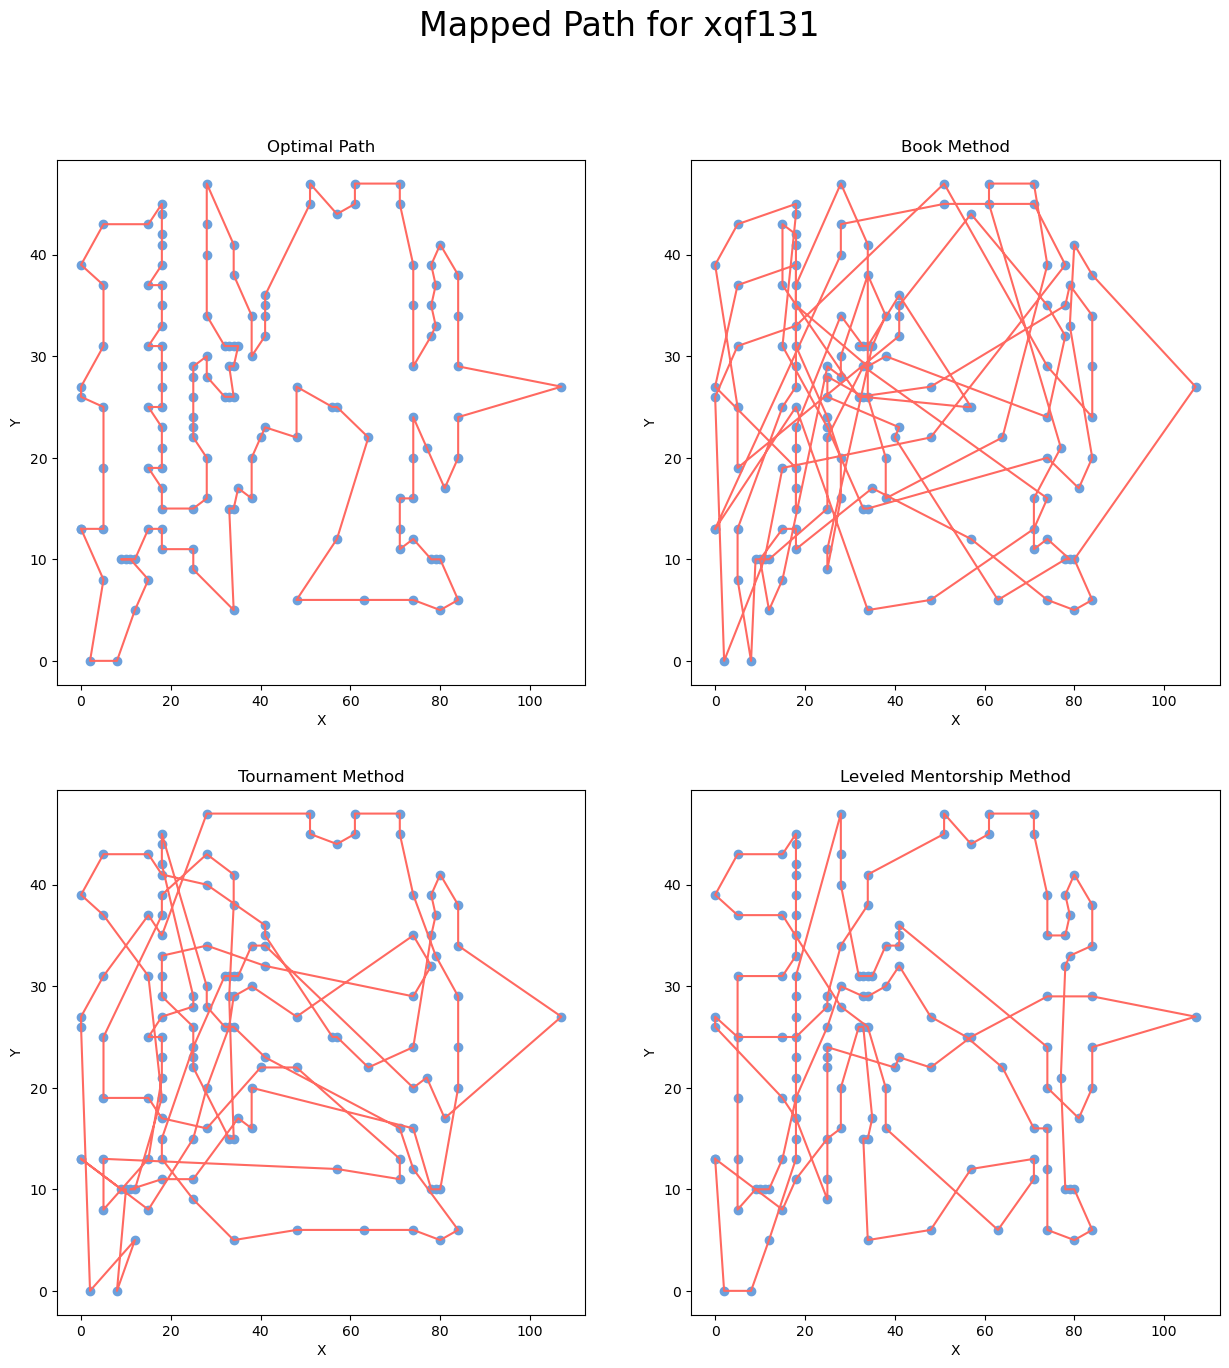

In [129]:
# print(np.array(tsp_1.cities_to_points(tsp_1.opt_tour)))

# print(np.array(tsp_1.cities_to_points(book_chromosomes[0].cities)))

fig, axs = plt.subplots(2, 2, figsize=(15, 15))

opt_points = np.array(tsp_1.cities_to_points(tsp_1.opt_tour)).T
axs[0, 0].plot(opt_points[0], opt_points[1], color = '#FF6961')
axs[0, 0].scatter(opt_points[0], opt_points[1], color = '#6CA0DC')
axs[0, 0].set_title('Optimal Path')
axs[0, 0].set_xlabel('X')
axs[0, 0].set_ylabel('Y')

book_points = np.array(tsp_1.cities_to_points(book_chromosomes[0].cities)).T
axs[0, 1].plot(book_points[0], book_points[1], color = '#FF6961')
axs[0, 1].scatter(book_points[0], book_points[1], color = '#6CA0DC')
axs[0, 1].set_title('Book Method')
axs[0, 1].set_xlabel('X')
axs[0, 1].set_ylabel('Y')

tourn_points = np.array(tsp_1.cities_to_points(tourn_chromosomes[0].cities)).T
axs[1, 0].plot(tourn_points[0], tourn_points[1], color = '#FF6961')
axs[1, 0].scatter(tourn_points[0], tourn_points[1], color = '#6CA0DC')
axs[1, 0].set_title('Tournament Method')
axs[1, 0].set_xlabel('X')
axs[1, 0].set_ylabel('Y')

mentor_points = np.array(tsp_1.cities_to_points(mentor_chromosomes[0].cities)).T
axs[1, 1].plot(mentor_points[0], mentor_points[1], color = '#FF6961')
axs[1, 1].scatter(mentor_points[0], mentor_points[1], color = '#6CA0DC')
axs[1, 1].set_title('Leveled Mentorship Method')
axs[1, 1].set_xlabel('X')
axs[1, 1].set_ylabel('Y')

fig.suptitle(f"Mapped Path for {path}", fontsize=24)
fig.savefig(f"maps_{path}.png")

plt.show()

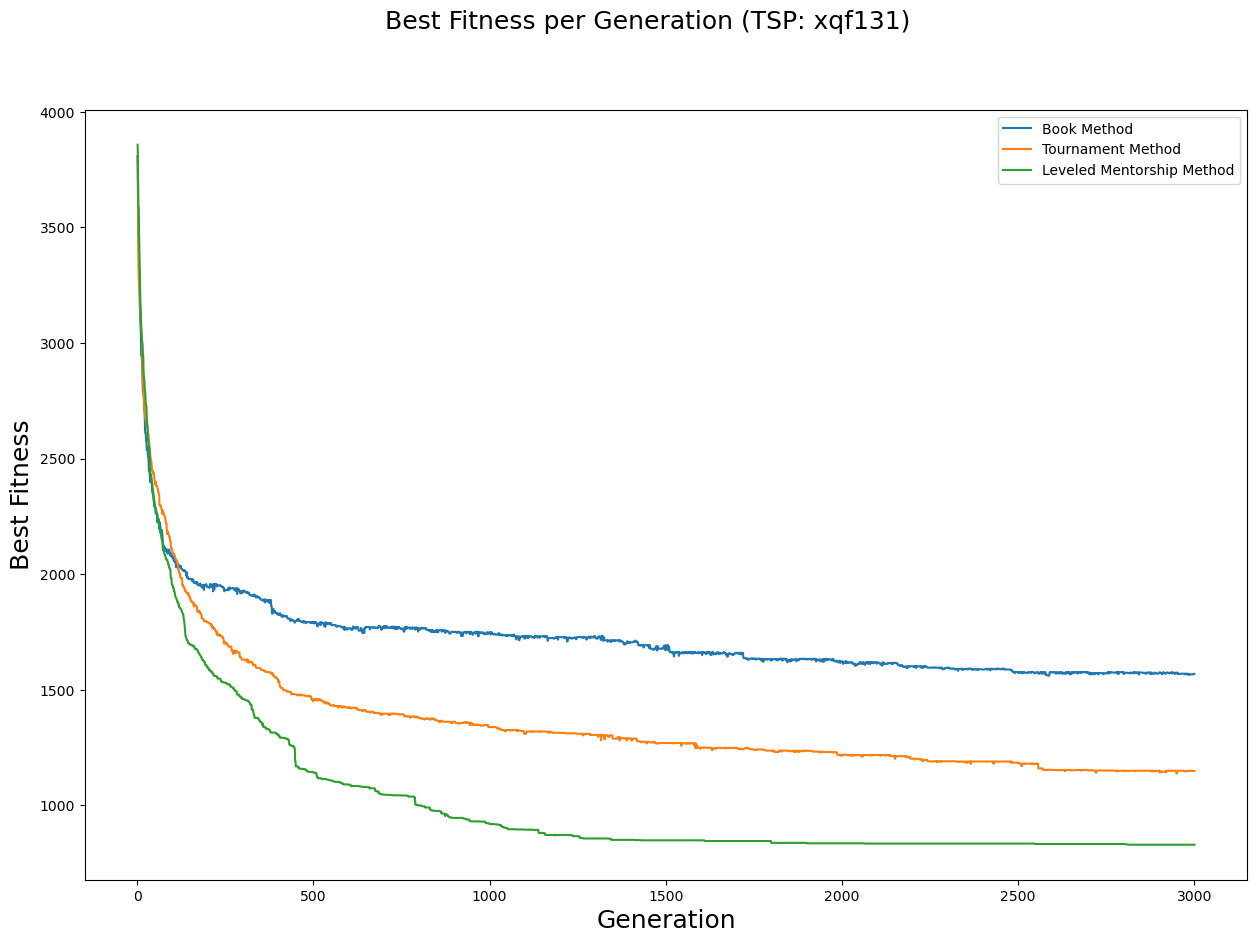

In [130]:
fig = plt.figure(figsize=(15, 10))
plt.plot([i+1 for i in range(num_generations)], book_fitness_over_gen, label="Book Method")
plt.plot([i+1 for i in range(num_generations)], tourn_fitness_over_gen, label="Tournament Method")
plt.plot([i+1 for i in range(num_generations)], mentor_fitness_over_gen, label="Leveled Mentorship Method")
fig.suptitle(f"Best Fitness per Generation (TSP: {path})", fontsize=18)
plt.xlabel("Generation", fontsize=18)
plt.ylabel("Best Fitness", fontsize=18)
plt.legend()
fig.savefig(f"best_fitness_{path}.png")

plt.show()

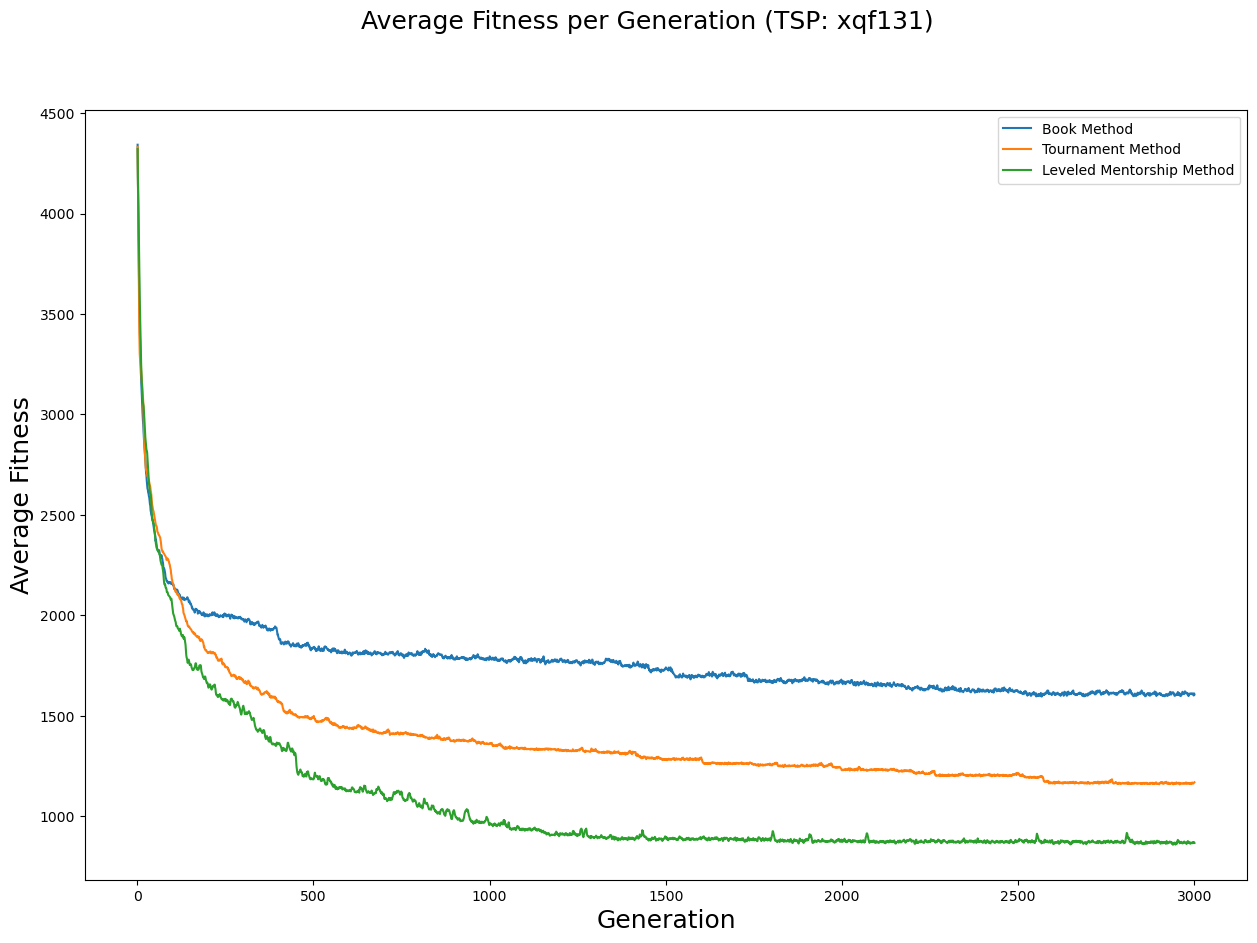

In [131]:
fig = plt.figure(figsize=(15, 10))
plt.plot([i+1 for i in range(num_generations)], book_avg_over_gen, label="Book Method")
plt.plot([i+1 for i in range(num_generations)], tourn_avg_over_gen, label="Tournament Method")
plt.plot([i+1 for i in range(num_generations)], mentor_avg_over_gen, label="Leveled Mentorship Method")
fig.suptitle(f"Average Fitness per Generation (TSP: {path})", fontsize=18)
plt.xlabel("Generation", fontsize=18)
plt.ylabel("Average Fitness", fontsize=18)
plt.legend()
fig.savefig(f"avg_fitness_{path}.png")

plt.show()